https://www.kaggle.com/c/petfinder-pawpularity-score/overview

Importing the requisite libraries

In [ ]:
import pandas as pd
import numpy as np
import os 
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split



Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = ('/content/drive/MyDrive/257/Project/petfinder-pawpularity-score')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(base_dir + '/train.csv')
sample_submission = pd.read_csv(base_dir + '/sample_submission.csv')

Adding on the location of image for each instance in the dataframe

In [ ]:
df['img_loc'] = ''
df['img_loc'] = "/train/" + df['Id'] + ".jpg"

In [ ]:
(df.head())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,img_loc
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/train/0007de18844b0dbbb5e1f607da0606e0.jpg
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/train/0009c66b9439883ba2750fb825e1d7db.jpg
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/train/0013fd999caf9a3efe1352ca1b0d937e.jpg
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/train/0018df346ac9c1d8413cfcc888ca8246.jpg
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/train/001dc955e10590d3ca4673f034feeef2.jpg


Normalizing the Pawpularity score. Now min/max is between 0/1

In [ ]:
#df_train = df_train[{'Id','Pawpularity'}]
df['Pawpularity'] /= 100
X = df.drop(['Pawpularity'], axis = 1)
y = df['Pawpularity']

Split the data for train test 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([train_dir, "{}_*".format(i + 1)])

In [ ]:
df.sample(5)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,img_loc
8418,d9ec50d15efde0919b2acafa4f47d141,0,1,1,1,0,0,0,0,0,0,0,0,0.17,/train/d9ec50d15efde0919b2acafa4f47d141.jpg
4688,787c7fbcc03f72bb4f9500d82e84d2eb,0,1,1,0,0,0,0,0,0,0,0,0,0.76,/train/787c7fbcc03f72bb4f9500d82e84d2eb.jpg
2790,47d5ad20bb1770fc0a618ca2e6a1620f,0,1,1,1,0,0,0,0,1,0,0,0,0.43,/train/47d5ad20bb1770fc0a618ca2e6a1620f.jpg
7210,b97b55a0728282ac73a174662d8bae23,0,1,1,1,0,0,0,0,0,0,0,0,0.38,/train/b97b55a0728282ac73a174662d8bae23.jpg
4600,75bbc4cb2239912d7ee1bfeff8e29e9a,0,1,1,1,0,0,0,0,0,0,0,0,0.29,/train/75bbc4cb2239912d7ee1bfeff8e29e9a.jpg


Importing fast AI library for the building the model

In [ ]:
!pip install fastai --upgrade -q
import fastai
from fastai.vision.all import *

In [ ]:
#collapse-hide
class FITSImage(TensorImage):
    @classmethod
    def create(cls, filename, chans=None, **kwargs) -> None:
        """Create FITS format image by using Astropy to open the file, and then 
        applying appropriate byte swaps and flips to get a Pytorch Tensor.
        """
        return cls(
            torch.from_numpy(
                astropy.io.fits.getdata(fn).byteswap().newbyteorder()
            )
            .flip(0)
            .float()
        )
    
    def show(self, ctx=None, ax=None, vmin=None, vmax=None, scale=True, title=None):
        """Plot using matplotlib or your favorite program here!"""
        pass
        
FITSImage.create = Transform(FITSImage.create) 

def FITSImageBlock(): 
    """A FITSImageBlock that can be used in the fastai DataBlock API.
    """
    return TransformBlock(partial(FITSImage.create))

Datablock which extracts data from dataframe as well as the corresponding image for each instance

Image size and crop location can be change and the model has varying degree of accuracy 

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['Id'], pref=f'{base_dir}/train/', suff='.jpg'),
    get_y=ColReader(['Pawpularity']),
    splitter=RandomSplitter(0.2),
    item_tfms=[CropPad(324)],# RandomCrop(112)],
    batch_tfms=aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + [Normalize],
)

In [ ]:
get_x=ColReader(['Id'], pref=f'{base_dir}/train/', suff='.jpg')

In [ ]:
get_y=ColReader(['Pawpularity'])

In [ ]:
splitter=RandomSplitter(0.2, seed=56)

In [ ]:
item_tfms=[CropPad(128), RandomCrop(900)]
batch_tfms=aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + [Normalize]

In [ ]:
dls = ImageDataLoaders.from_dblock(dblock, df, path = base_dir, bs=64)

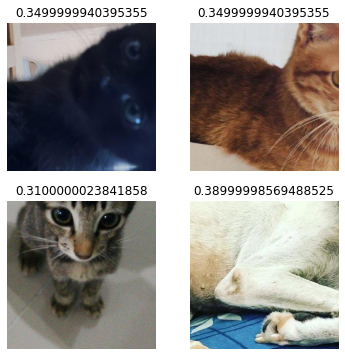

In [ ]:
dls.show_batch(nrows=2, ncols=2)

U

Using Resnet34 for image classification

In [ ]:
xresnet9 = XResNet(ResBlock, expansion=1, layers=[1, 1, 1, 1]) 

In [ ]:
model = xresnet34(n_out=dls.c, sa=True)

Using RMSE as a matrix as per the kaggle competition

In [ ]:
def root_mean_squared_error(p, y): 
    return torch.sqrt(F.mse_loss(p.view(-1), y.view(-1)))

In [ ]:
learn = Learner(
    dls, 
    model,
    opt_func=ranger, 
    loss_func=root_mean_squared_error
)

Using GPU for processing

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


SuggestedLRs(valley=0.0012022644514217973)

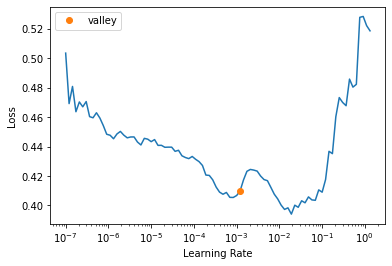

In [ ]:
learn.lr_find()

**The best model had the RMSE score of 0.20 or around 20 points error for the Pawpularity score**

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.266591,0.287191,07:40
1,0.226399,0.212665,03:56
2,0.216004,0.212873,03:55
3,0.205141,0.210400,03:55
4,0.202246,0.209300,03:56


Plot the results

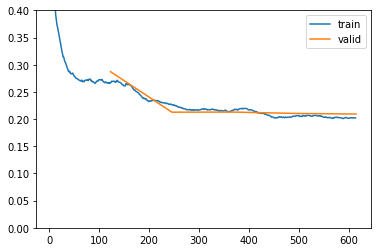

In [ ]:
learn.recorder.plot_loss()
plt.ylim(0, 0.4);